## Libraries and datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from unidecode import unidecode
from sklearn.metrics import mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import ks_2samp
from sklearn.linear_model import BayesianRidge, Ridge

c:\Users\chiar\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.impute import IterativeImputer, SimpleImputer

In [3]:
dataset_cyclists = load_dataset('csv', data_files='dataset/cyclists.csv')
dataset_races = load_dataset('csv', data_files='dataset/races_fixed_delta.csv')

df_cyclists = dataset_cyclists['train'].to_pandas()
df_races = dataset_races['train'].to_pandas()

Generating train split: 589865 examples [00:03, 165699.39 examples/s]


## Cyclists

In [4]:
df_cyclists.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


Check for duplicates names --> we searched, and they actually are different person with same name but also different nationality

### Defining Kolmogorov-Smirnov Test to compare the distribution before and after the imputations

In [5]:
def test_before_after_distribution(before, after):
    statistic, p_value = ks_2samp(before, after)

    # Print test results
    print(f"\nKS Test: Statistic = {statistic}, p-value = {p_value}")

    if statistic < 0.05:
        print("Very small difference in distribution, the imputed data closely matches the original distribution.")
    elif 0.05 <= statistic < 0.1:
        print("Minor difference in distribution, the imputed data is similar to the original distribution with slight deviations.")
    elif 0.1 <= statistic < 0.2:
        print("Moderate difference in distribution, the imputed data shows some noticeable deviations from the original distribution.")
    elif 0.2 <= statistic < 0.5:
        print("Significant difference in distribution, the imputed data may not fully preserve the original distribution.")
    else:
        print("Large difference in distribution, the imputed data differs substantially from the original distribution.")

Interpretation
Statistic (0.0167): The KS statistic is a measure of the maximum difference between the cumulative distributions of the two samples (before and after imputation). Here, the statistic is small (0.0167), suggesting only a slight difference in shape between the two distributions.

P-value (7.42e-62): This extremely low p-value indicates that even this small difference is statistically significant. This could be probably due to large sample size

### Pre processing needed for cyclists 

#### Scott-davies has no info, so just delete him from cyclist (also in races he is not relevant)

In [6]:
# Check information about scott-davies in the other dataset to put some value in
df_cyclists[df_cyclists["_url"] == "scott-davies"] # --> No info

,_url,name,birth_year,weight,height,nationality
9,scott-davies,Scott Davies,NaN,NaN,NaN,None


In [7]:
# Delete scott-davies row
df_cyclists = df_cyclists[df_cyclists["_url"] != "scott-davies"]

### Count of missing values

In [8]:
df_cyclists.isnull().sum()

_url              0
name              0
birth_year       12
weight         3055
height         2990
nationality       0
dtype: int64

### Birth_year

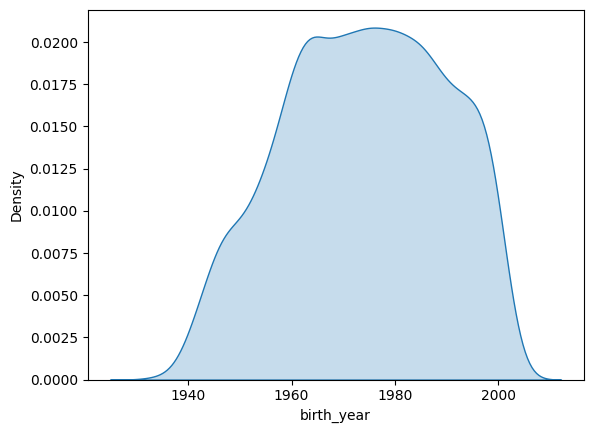

In [9]:

birth_year_before_imputation = df_cyclists['birth_year'].copy()

seaborn.kdeplot(df_cyclists["birth_year"], fill=True, label="birth_year")
plt.show()



In [10]:
imputer = SimpleImputer(strategy='mean')
imputer.fit((df_cyclists[["birth_year"]]))
df_cyclists["birth_year"] = imputer.transform(df_cyclists[["birth_year"]]).squeeze()


df_cyclists["birth_year"].isnull().sum()


np.int64(0)

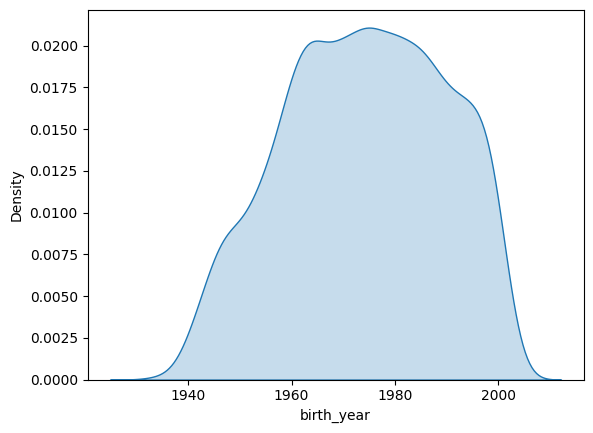

In [11]:
seaborn.kdeplot(df_cyclists["birth_year"], fill=True, label="birth_year")
plt.show()

In [12]:
birth_year_after_imputation = df_cyclists['birth_year'].copy() 

test_before_after_distribution(birth_year_before_imputation.dropna(), birth_year_after_imputation)



KS Test: Statistic = 0.0009794328426410664, p-value = 1.0
Very small difference in distribution, the imputed data closely matches the original distribution.


### Weight and height

In [13]:
weight_before_imputation = df_cyclists['weight'].copy()
height_before_imputation = df_cyclists['height'].copy()

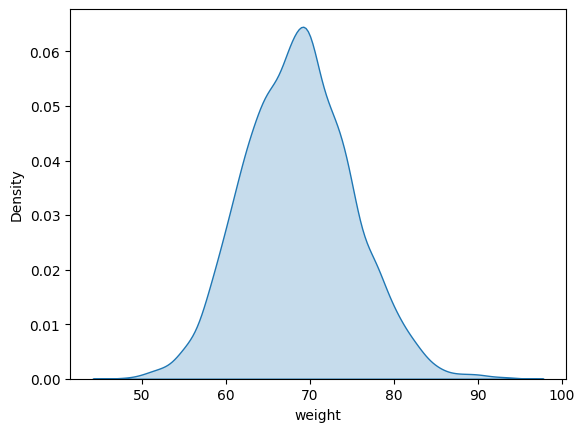

In [14]:
# Plot weight distribution
seaborn.kdeplot(df_cyclists["weight"], fill=True, label="weight")
plt.show()

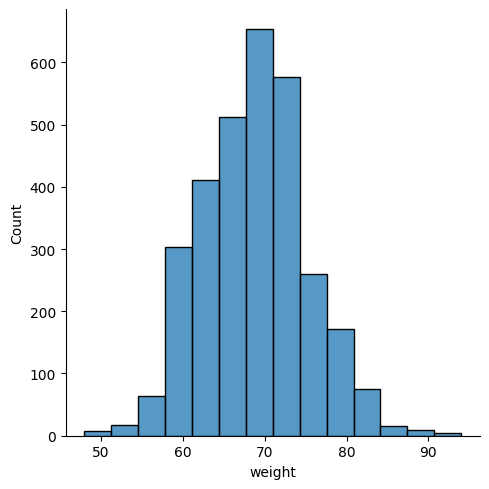

In [15]:
# weight
seaborn.displot(df_cyclists,
                x="weight",
                kind="hist",
                row_order="desc",
                bins=14)

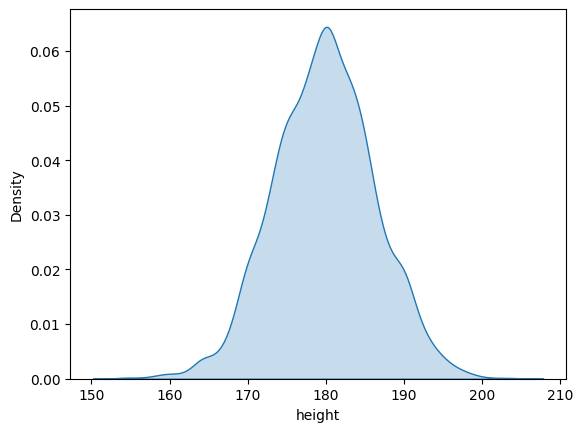

In [16]:
# Plot height distribution
seaborn.kdeplot(df_cyclists["height"], fill=True, label="height")
plt.show()

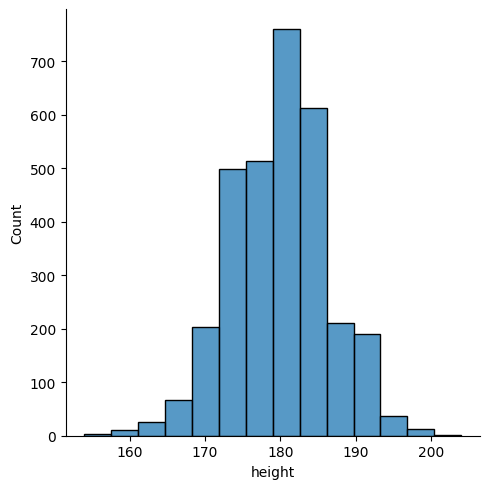

In [17]:
# height
seaborn.displot(df_cyclists,
                x="height",
                kind="hist",
                row_order="desc",
                bins=14)

In [18]:
# Keep the _url in the imputation dataset to preserve the reference
df_cyclists_impute_scaling = df_cyclists[['height', 'weight', '_url']].copy()

print("Shape of original DataFrame:", df_cyclists.shape)
print("Shape of imputed DataFrame:", df_cyclists_impute_scaling.shape)

# Normalize/Scale only weight and height (not _url)
scaler = StandardScaler()
df_cyclists_impute_scaling[['weight', 'height']] = scaler.fit_transform(df_cyclists_impute_scaling[['weight', 'height']])

# Initialize Iterative Imputer (Bayesian Ridge for imputation)
iterative_imputer = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=0,
    max_iter=100,
    sample_posterior=True
)

# Fit the imputer and transform the DataFrame (excluding '_url' from the imputation)
imputed_values = iterative_imputer.fit_transform(df_cyclists_impute_scaling[['weight', 'height']])

# Revert scaling for the imputed values
df_imputed_scaling = pd.DataFrame(
    scaler.inverse_transform(imputed_values),  
    columns=['weight', 'height']
)

# Add back the _url column to the imputed DataFrame (preserve cyclist id)
df_imputed_scaling['_url'] = df_cyclists_impute_scaling['_url'].values

# Now you have df_imputed_scaling with _url, weight, and height
print("\nImputed DataFrame:\n", df_imputed_scaling)

# Merge the imputed values back into the original dataset using _url as the key
df_cyclists = df_cyclists.merge(
    df_imputed_scaling[['weight', 'height', '_url']], 
    on='_url', 
    how='left', 
    suffixes=('', '_imputed')
)

# Replace original columns with the imputed values where available
df_cyclists['weight'] = df_cyclists['weight_imputed'].fillna(df_cyclists['weight'])
df_cyclists['height'] = df_cyclists['height_imputed'].fillna(df_cyclists['height'])

# Drop the temporary '_imputed' columns
df_cyclists.drop(columns=['weight_imputed', 'height_imputed'], inplace=True)

weight_after_imputation = df_cyclists['weight'].copy()
height_after_imputation = df_cyclists['height'].copy()

# Now df_cyclists has the updated weight and height columns
print("Updated DataFrame with Imputed Values:\n", df_cyclists)

Shape of original DataFrame: (6133, 6)
Shape of imputed DataFrame: (6133, 3)

Imputed DataFrame:
          weight      height                     _url
0     70.057068  187.223027              bruno-surra
1     74.000000  182.000000               gerard-rue
2     69.000000  189.000000                 jan-maas
3     78.000000  192.000000     nathan-van-hooydonck
4     55.000000  171.000000         jose-felix-parra
...         ...         ...                      ...
6128  72.105507  187.435327  juan-jose-martinez-diaz
6129  75.000000  188.000000           inigo-elosegui
6130  58.906714  167.861711           paolo-alberati
6131  58.000000  170.000000        jackson-rodriguez
6132  75.000000  186.000000             ward-vanhoof

[6133 rows x 3 columns]
Updated DataFrame with Imputed Values:
                          _url                  name  birth_year     weight  \
0                 bruno-surra          Bruno  Surra      1964.0  70.057068   
1                  gerard-rue           Gérar

Plot distributions after imputing

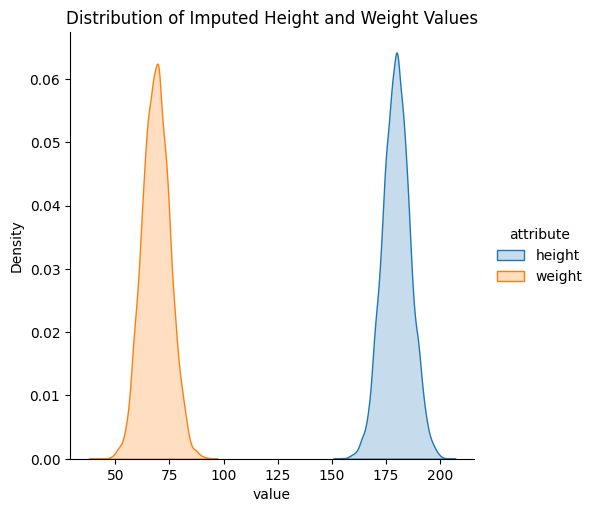

In [19]:
# Visualize the distributions of imputed height and weight
df_long = pd.melt(df_cyclists, value_vars=['height', 'weight'], var_name='attribute', value_name='value')

seaborn.displot(df_long, x='value', hue='attribute', kind='kde', fill=True, common_norm=False)
plt.title('Distribution of Imputed Height and Weight Values')
plt.show()

In [20]:
test_before_after_distribution(weight_before_imputation.dropna(), weight_after_imputation)


KS Test: Statistic = 0.03005084287676877, p-value = 0.04808327779022059
Very small difference in distribution, the imputed data closely matches the original distribution.


In [21]:
df_cyclists.isnull().sum()

_url           0
name           0
birth_year     0
weight         0
height         0
nationality    0
dtype: int64

## Races

In [22]:
df_races.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,amstel-gold-race/1970/result,Amstel Gold Race,225.0,NaN,240000.0,NaN,NaN,372,NaN,1970-04-25 06:21:30,0,georges-pintens,24.0,False,False,False,norway-1987,0.0
1,amstel-gold-race/1970/result,Amstel Gold Race,225.0,NaN,240000.0,NaN,NaN,372,NaN,1970-04-25 06:21:30,1,willy-van-neste,26.0,False,False,False,norway-1987,0.0
2,amstel-gold-race/1970/result,Amstel Gold Race,225.0,NaN,240000.0,NaN,NaN,372,NaN,1970-04-25 06:21:52,2,andre-dierickx,23.0,False,False,False,spain-1991,22.0
3,amstel-gold-race/1970/result,Amstel Gold Race,225.0,NaN,240000.0,NaN,NaN,372,NaN,1970-04-25 06:22:03,3,eric-leman,24.0,False,False,False,spain-1991,11.0
4,amstel-gold-race/1970/result,Amstel Gold Race,225.0,NaN,240000.0,NaN,NaN,372,NaN,1970-04-25 06:22:03,4,joseph-schoeters,23.0,False,False,False,None,0.0


### Missing values

In [23]:
# check missing values
df_races.isnull().sum()

_url                        0
name                        0
points                    477
uci_points             338779
length                      0
climb_total            147045
profile                148194
startlist_quality           0
average_temperature    559932
date                        0
position                    0
cyclist                     0
cyclist_age               113
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64

In [24]:
percent_missing = df_races.isnull().sum() * 100 / len(df_races) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': df_races.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url                    0.000000
name                    0.000000
points                  0.080866
uci_points             57.433311
length                  0.000000
climb_total            24.928585
profile                25.123376
startlist_quality       0.000000
average_temperature    94.925449
date                    0.000000
position                0.000000
cyclist                 0.000000
cyclist_age             0.019157
is_tarmac               0.000000
is_cobbled              0.000000
is_gravel               0.000000
cyclist_team           26.982615
delta                   0.000000
Name: percent_missing, dtype: float64

### Average Temperature
There are too much missing values --> just delete it

In [25]:
# Delete the 'average_temperature' column
df_races = df_races.drop(columns=['average_temperature'])
df_races.isnull().sum()

_url                      0
name                      0
points                  477
uci_points           338779
length                    0
climb_total          147045
profile              148194
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age             113
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         159161
delta                     0
dtype: int64

### Date

Delete noise of timestamp and leave year/month/day. Plus create a new column with only the year of the race (useful for imputation later)

In [26]:
df_races['date'] = df_races['date'].str.split(' ').str[0]
df_races['date'] = pd.to_datetime(df_races['date'], format='%Y-%m-%d')

# new column year
df_races['year'] = df_races['date'].dt.year

### Name

same url, but different names nomenclature. Also the ME prefix --> there are no different races (ME and not ME) in the same year... So just replace with original name

In [27]:
df_races[df_races['name'].notnull()].groupby(by='name', observed=True)['name'].value_counts()

name
Amstel Gold Race                       4349
Clasica Ciclista San Sebastian         3884
Clásica Ciclista San Sebastian           84
Clásica Ciclista San Sebastián          236
Clásica San Sebastián                    52
                                      ...  
Vuelta Ciclista al País Vasco          6529
Vuelta a España                       89222
Vuelta al País Vasco                   7206
World Championships - Road Race        1611
World Championships ME - Road Race     2306
Name: count, Length: 61, dtype: int64

In [28]:
len(df_races['name'].unique())

61

In [29]:
# check if there are two different rafes (ME and not ME) in the same year --> NO

tmp_df = tmp_df = pd.DataFrame({
    'name': df_races['name'],
    'year': df_races['date'].dt.year,
    'general_name': df_races['name'].apply(lambda x: x.split('ME')[0].strip()),
})

n_name = tmp_df.groupby(by=['general_name', 'year'], observed=True)['name'].nunique()

n_name_gt1 = n_name[n_name > 1]
round(len(n_name_gt1) / len(n_name) * 100, 2)

0.0

In [30]:
df_races['name'] = df_races['name'].apply(unidecode)
df_races['name'] = df_races['name'].replace(to_replace={'Clasica Ciclista San Sebastian':'Clasica San Sebastian',
                                                      'Donostia San Sebastian Klasikoa':'Clasica San Sebastian',
                                                         'Criterium du Dauphine Libere':'Criterium du Dauphine',
                                                         'Gran Camino':'O Gran Camino',
                                                         'La Vuelta ciclista a Espana':'Vuelta a Espana',
                                                         'Dwars door Belgie / A travers la Belgique':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen - A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'Dwars door Vlaanderen / A travers la Flandre':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen / A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'E3 BinckBank Classic':'E3 Saxo Bank Classic',
                                                         'E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen - Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Saxo Classic':'E3 Saxo Bank Classic',
                                                         'E3-Prijs Harelbeke':'E3 Saxo Bank Classic',
                                                         'Record Bank E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'Giro di Lombardia':'Il Lombardia',
                                                         'Liege - Bastogne - Liege':'Liege-Bastogne-Liege',
                                                         'Monte Paschi Eroica':'Strade Bianche',
                                                         'Montepaschi Strade Bianche - Eroica Toscana':'Strade Bianche',
                                                         'Omloop Het Volk':'Omloop Nieuwsblad',
                                                         'Omloop Het Nieuwsblad ME':'Omloop Nieuwsblad ME',
                                                         'Omloop Het Volk ME':'Omloop Nieuwsblad ME',
                                                         'Paris - Roubaix':'Paris-Roubaix',
                                                         'Ronde van Vlaanderen - Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Ronde van Vlaanderen / Tour des Flandres':'Ronde van Vlaanderen',
                                                         'Ronde van Vlaanderen / Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Volta a Catalunya':'Volta Ciclista a Catalunya',
                                                         'Vuelta Ciclista al Pais Vasco':'Vuelta al Pais Vasco',
                                                         })

df_races['name'] = df_races['name'].replace(to_replace={
                                                         'Dwars door Vlaanderen ME':'Dwars door Vlaanderen',
                                                         'Omloop Nieuwsblad ME':'Omloop Nieuwsblad',
                                                         'Ronde van Vlaanderen ME':'Ronde van Vlaanderen',
                                                         'World Championships ME - Road Race':'World Championships - Road Race'
                                                         })

### Cyclist age

In [31]:
dataset_races_copy = load_dataset('csv', data_files='dataset/races.csv')

df_races_copy = dataset_races_copy['train'].to_pandas()

In [32]:
age_before_imputation = df_races_copy['cyclist_age'].copy()

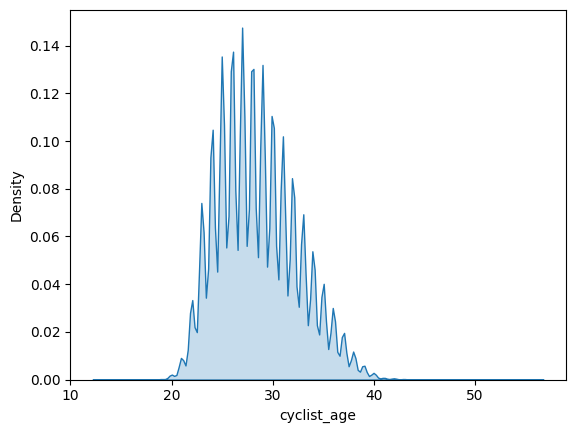

In [33]:
# Kernel Density Estimation
seaborn.kdeplot(df_races["cyclist_age"], fill=True, label="cyclist_age")
plt.show()

Since one cyclists can run multiple races, for matching we have to remove duplicates

In [34]:
df_cyclists_clean = df_cyclists.drop_duplicates(subset=['_url'])
df_races_clean = df_races.drop_duplicates(subset=['cyclist'])

# Print counts after removing duplicates
print(df_cyclists_clean["_url"].count())
print(df_races_clean["cyclist"].count())

# Merge the two DataFrames based on matches between '_url' and 'cyclist'
matches = df_cyclists_clean.merge(df_races_clean, left_on='_url', right_on='cyclist', how='inner')

# Count the number of unique matches
number_of_matches = len(matches)
number_of_matches

6133
6095


6094

In [35]:
matches.head()

,_url_x,name_x,birth_year,weight,height,nationality,_url_y,name_y,points,uci_points,...,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,year
0,bruno-surra,Bruno Surra,1964.0,70.057068,187.223027,Italy,vuelta-a-espana/1989/stage-1,Vuelta a Espana,80.0,NaN,...,1989-04-24,110,bruno-surra,25.0,True,False,False,None,0.0,1989
1,gerard-rue,Gérard Rué,1965.0,74.000000,182.000000,France,amstel-gold-race/1993/result,Amstel Gold Race,225.0,NaN,...,1993-04-24,77,gerard-rue,28.0,False,False,False,czechoslovakia-1987,0.0,1993
2,jan-maas,Jan Maas,1996.0,69.000000,189.000000,Netherlands,amstel-gold-race/2022/result,Amstel Gold Race,225.0,500.0,...,2022-04-10,39,jan-maas,26.0,False,False,False,munck-beck-s-1975,0.0,2022
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.000000,192.000000,Belgium,amstel-gold-race/2022/result,Amstel Gold Race,225.0,500.0,...,2022-04-10,38,nathan-van-hooydonck,27.0,False,False,False,colombia-selle-italia-2002,0.0,2022
4,jose-felix-parra,José Félix Parra,1997.0,55.000000,171.000000,Spain,gran-camino/2023/stage-2,O Gran Camino,20.0,14.0,...,2023-02-24,55,jose-felix-parra,26.0,True,False,False,atala-1985,0.0,2023


In [36]:
# check missing values
matches.isnull().sum()

_url_x                  0
name_x                  0
birth_year              0
weight                  0
height                  0
nationality             0
_url_y                  0
name_y                  0
points                  0
uci_points           4588
length                  0
climb_total          3773
profile              3668
startlist_quality       0
date                    0
position                0
cyclist                 0
cyclist_age            12
is_tarmac               0
is_cobbled              0
is_gravel               0
cyclist_team         3367
delta                   0
year                    0
dtype: int64

Check for cyclists that has made more than one race --> useful for later because of duplicates

In [37]:
# Step 1: Identify rows with missing cyclist_age in df_races
df_missing_age = df_races[df_races["cyclist_age"].isnull()]

# Step 2: Group by cyclist and count the number of races (rows) for each cyclist with missing age
duplicate_cyclists = df_missing_age.groupby("cyclist").size().reset_index(name="race_count")

# Step 3: Filter for cyclists who have more than one race with a missing age
duplicate_cyclists = duplicate_cyclists[duplicate_cyclists["race_count"] > 1]

# Display cyclists with more than one missing cyclist_age entry
print(duplicate_cyclists)


# Check total count of missing cyclist_age values in df_races
missing_count = df_races["cyclist_age"].isnull().sum()
print("Total missing cyclist_age values:", missing_count)

               cyclist  race_count
0      alexandr-osipov          13
1       antonio-zanini           2
7     nicolai-kosyakov          11
9         scott-davies          52
10  sergei-jermachenko          14
12    vladimir-malakov          14
Total missing cyclist_age values: 113


We can manually impute 13 missing values for cyclist_age since we have the year of the race and the nationality of the cyclist

In [38]:
# Extract race year from the url
matches["_year"] = matches["_url_y"].str.extract(r'/(\d{4})/').astype(int)

# Convert birth_year to integer
matches["birth_year"] = matches["birth_year"].astype(int)

# Compute cyclist_age where it is null
matches["cyclist_age"] = np.where(
    matches["cyclist_age"].isnull(),
    matches["_year"] - matches["birth_year"],
    matches["cyclist_age"]
)

# Identify the subset of cyclists with missing cyclist_age in df_races
# We'll filter out cyclists with missing cyclist_age in df_races
df_missing_age = df_races[df_races["cyclist_age"].isnull()]

# Filter only the cyclists from matches that are common with df_races and have missing ages
# 'cyclist' column is used to match both datasets
matches_with_missing_age = matches[matches["cyclist"].isin(df_missing_age["cyclist"])]

# Update df_races with the imputed cyclist_age values for only the matched cyclists
# We will do this based on the 'cyclist' column
df_races.loc[df_races["cyclist"].isin(matches_with_missing_age["cyclist"]), "cyclist_age"] = \
    df_races["cyclist"].map(matches_with_missing_age.set_index("cyclist")["cyclist_age"])

In [39]:
# check missing values
df_races.isnull().sum()

_url                      0
name                      0
points                  477
uci_points           338779
length                    0
climb_total          147045
profile              148194
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age              52
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         159161
delta                     0
year                      0
dtype: int64

#### Check which cyclist have no age yet  --> only scott-davies who is not present on the other datasets because we deleted him (all NaN values)

In [40]:
# Check which cyclist have no age yet 
cyclists_with_no_age_yet = df_races[df_races["cyclist_age"].isnull()]
cyclists_with_no_age_yet

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,year
3908,amstel-gold-race/2018/result,Amstel Gold Race,225.0,500.0,263000.0,3496.0,2.0,1139,2018-04-15,96,scott-davies,NaN,False,False,False,liquigas-2007,0.0,2018
116109,giro-d-italia/2019/stage-1,Giro d'Italia,80.0,100.0,8000.0,291.0,3.0,896,2019-05-11,42,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0,2019
116398,giro-d-italia/2019/stage-10,Giro d'Italia,80.0,100.0,145000.0,160.0,1.0,896,2019-05-21,147,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0,2019
116561,giro-d-italia/2019/stage-11,Giro d'Italia,80.0,100.0,221000.0,476.0,1.0,896,2019-05-22,156,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0,2019
116678,giro-d-italia/2019/stage-12,Giro d'Italia,80.0,100.0,158000.0,1918.0,4.0,896,2019-05-23,111,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0,2019
116822,giro-d-italia/2019/stage-13,Giro d'Italia,80.0,100.0,196000.0,5187.0,5.0,896,2019-05-24,96,scott-davies,NaN,True,False,False,team-giant-shimano-2014,4.0,2019
116976,giro-d-italia/2019/stage-14,Giro d'Italia,80.0,100.0,131000.0,4187.0,4.0,896,2019-05-25,99,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0,2019
117109,giro-d-italia/2019/stage-15,Giro d'Italia,80.0,100.0,232000.0,3122.0,3.0,896,2019-05-26,83,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0,2019
117245,giro-d-italia/2019/stage-16,Giro d'Italia,80.0,100.0,194000.0,5207.0,4.0,896,2019-05-28,71,scott-davies,NaN,True,False,False,team-giant-shimano-2014,71.0,2019
117415,giro-d-italia/2019/stage-17,Giro d'Italia,80.0,100.0,181000.0,3482.0,5.0,896,2019-05-29,96,scott-davies,NaN,True,False,False,team-giant-shimano-2014,0.0,2019


#### So... delete all 52 null values since they refer only to sott-davies for which we have no info

In [41]:
# delete 52 null values since they refer only to sott-davies for which we have no info
df_races = df_races[~df_races['cyclist'].isin(cyclists_with_no_age_yet['cyclist'])].copy()

age_after_imputation = df_races['cyclist_age'].copy()

In [42]:
test_before_after_distribution(age_before_imputation.dropna(), age_after_imputation)


KS Test: Statistic = 9.582254068141172e-05, p-value = 1.0
Very small difference in distribution, the imputed data closely matches the original distribution.


### Compute optimal number of bins

In [43]:
# Sturges rule for approximately Normal distributions
def sturges_bin_count(df_races):
    """Calculate optimal number of bins based on Sturges' rule"""
    return int(np.ceil(np.log2(len(df_races)) + 1))

bins = sturges_bin_count(df_races["cyclist_age"])
print(f"Recommended number of bins: {bins}")

# Freedman-Diaconis Rule is better for data with outliers and skewed distributions
def freedman_diaconis_bin_count(data):
    """Calculate optimal number of bins based on Freedman-Diaconis rule"""
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * iqr * len(data) ** (-1/3)
    return int(np.ceil((data.max() - data.min()) / bin_width))

bins = freedman_diaconis_bin_count(df_races["cyclist_age"])
print(f"Recommended number of bins: {bins}")

Recommended number of bins: 21
Recommended number of bins: 378


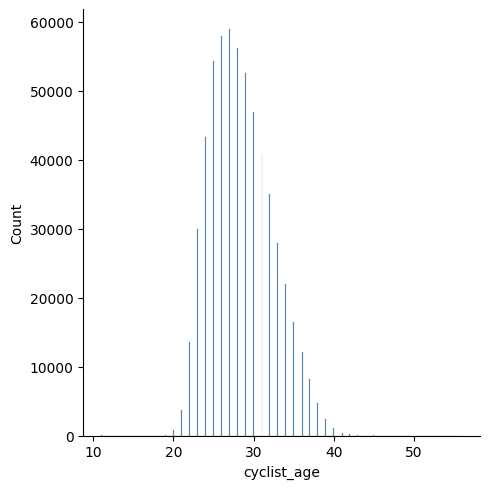

In [44]:
# birht year
seaborn.displot(df_races,
                x="cyclist_age",
                kind="hist",
                row_order="desc",
                bins=378)

In [45]:
df_races.isnull().sum() # zero missing value for age

_url                      0
name                      0
points                  477
uci_points           338779
length                    0
climb_total          147045
profile              148194
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         159161
delta                     0
year                      0
dtype: int64

### Impute climb total and profile together using race characteristics (race length, race type).

See distributions first

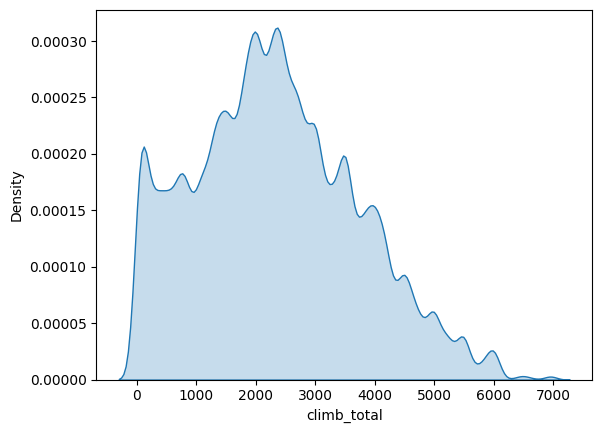

In [46]:
# Kernel Density Estimation
seaborn.kdeplot(df_races["climb_total"], fill=True, label="climb_total")
plt.show()

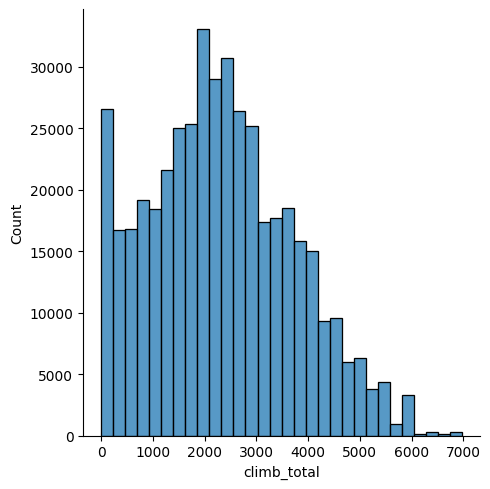

In [47]:
seaborn.displot(df_races,
                x="climb_total",
                kind="hist",
                row_order="desc",
                bins=30)

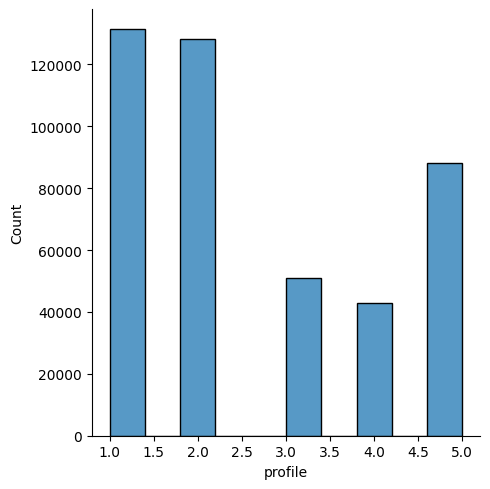

In [48]:
seaborn.displot(df_races,
                x="profile",
                kind="hist",
                row_order="desc",
                bins=10)

In [49]:
# compute for test differences after imputation
climb_total_before_imputation = df_races['climb_total'].dropna().copy() 

#### Reduce Skeweness

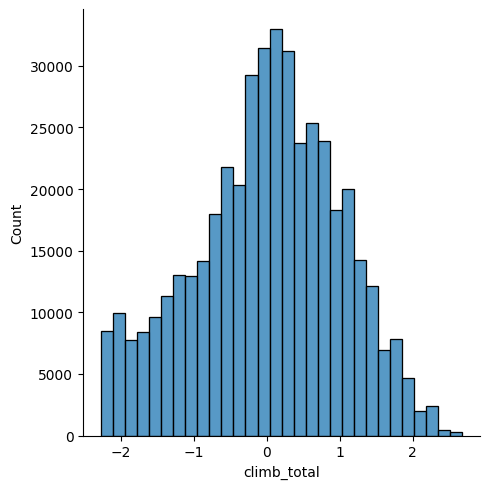

In [50]:
# Apply Yeo-Johnson transformation to reduce skeweness --> OKAY
pt = PowerTransformer(method='yeo-johnson')
df_races['climb_total'] = pt.fit_transform(df_races[['climb_total']])

#bins = sturges_bin_count(df_races["climb_total"])
seaborn.displot(df_races,
            x="climb_total",
            kind="hist",
            row_order="desc",
            bins=30)

#### IterativeImputer with KNNRegressor

   climb_total  profile
0       3941.0      2.0
1       3941.0      2.0
2       3941.0      2.0
3       3941.0      2.0
4       3941.0      2.0


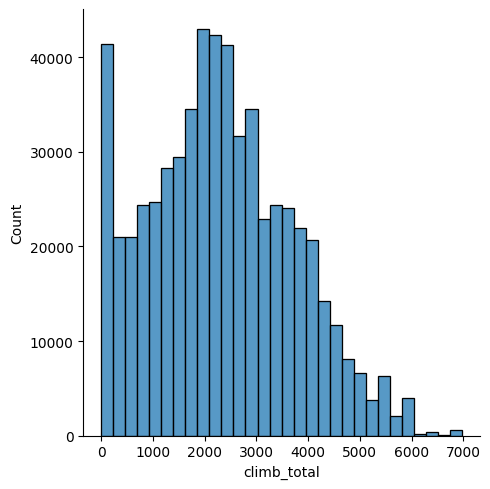

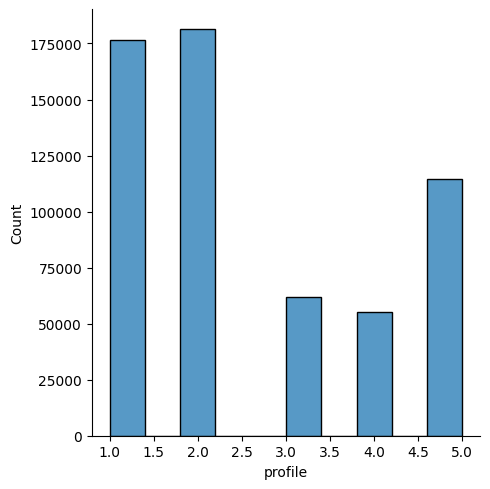

In [51]:
# Scale 
scaler = StandardScaler()
df_races[['climb_total', 'profile', 'length']] = scaler.fit_transform(df_races[['climb_total', 'profile', 'length']])

iterative_imputer = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=3), # 3 is empirical, watching the distr after imputation
    random_state=0,
    max_iter=100,
    sample_posterior=False
)

df_races[['climb_total', 'profile', 'length']] = iterative_imputer.fit_transform(df_races[['climb_total', 'profile', 'length']])

# Inverse the standardization for 'climb_total' and 'profile'
df_races[['climb_total', 'profile', 'length']] = scaler.inverse_transform(df_races[['climb_total', 'profile', 'length']])

# Inverse the Yeo-Johnson transformation on 'climb_total'
df_races['climb_total'] = pt.inverse_transform(df_races[['climb_total']])

# Visualize the distributions of imputed 'climb_total' values
#bins = sturges_bin_count(df_races["climb_total"])
#print(bins)
seaborn.displot(df_races, x="climb_total", kind="hist", bins=30)

# Visualize the distributions of imputed 'profile' values
#bins_profile = sturges_bin_count(df_races["profile"])
seaborn.displot(df_races, x="profile", kind="hist", bins=10)

# Display the updated DataFrame with both imputed columns
print(df_races[['climb_total', 'profile']].head())


In [52]:
climb_total_after_imputation = df_races['climb_total']

test_before_after_distribution(climb_total_before_imputation, climb_total_after_imputation)


KS Test: Statistic = 0.010555459709319072, p-value = 6.633120236693802e-25
Very small difference in distribution, the imputed data closely matches the original distribution.


In [53]:
df_races.isnull().sum()

_url                      0
name                      0
points                  477
uci_points           338779
length                    0
climb_total               0
profile                   0
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         159161
delta                     0
year                      0
dtype: int64

### Points 

Points depends on the stage and the year, not on the name and the year. In different years, there are equal races with different points --> so we checked if this could depend from the stage (_url) --> YES

In [54]:
# check if points depends by year and name
tmp_df = tmp_df = pd.DataFrame({
    '_url': df_races['_url'],
    'name': df_races['name'],
    'year': df_races['date'].dt.year,
    'points': df_races['points'],
    'uci_points': df_races['uci_points']
})

n_points = tmp_df.groupby(['year', 'name'])['points'].nunique()
n_points = n_points[n_points > 1]
n_points

year  name                 
1999  Tour de France           2
2000  Tour de France           2
2001  Tour de France           2
2002  Giro d'Italia            2
      Tour de France           2
2003  Tour de France           2
2004  Tour de France           2
      Vuelta a Espana          2
2005  Criterium du Dauphine    2
      Giro d'Italia            2
      Tour de France           3
      Tour de Suisse           2
      Vuelta a Espana          2
2006  Criterium du Dauphine    3
      Giro d'Italia            2
      Tirreno-Adriatico        2
      Tour de Suisse           2
2008  Paris - Nice             2
      Tirreno-Adriatico        2
2009  Giro d'Italia            3
Name: points, dtype: int64

In [55]:
# check if points depends on stage and year
n_points = tmp_df.groupby(['name', '_url'])['points'].nunique()
n_points = n_points[n_points > 1]
n_points

Series([], Name: points, dtype: int64)

In [56]:
# Compute for testing after imputation
points_before_imputation = df_races['points'].dropna().copy()

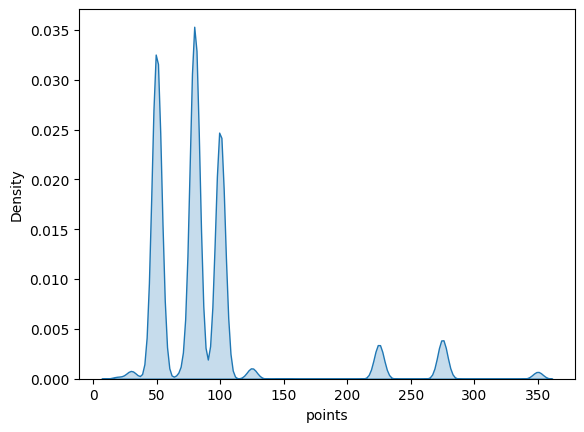

In [57]:
# Kernel Density Estimation
seaborn.kdeplot(df_races["points"], fill=True, label="points")
plt.show()

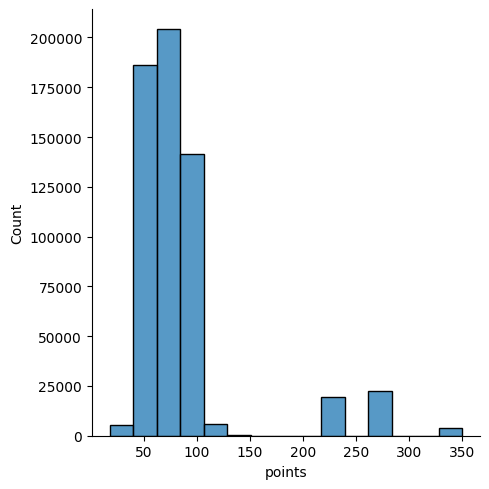

In [58]:
seaborn.displot(df_races,
            x="points",
            kind="hist",
            row_order="desc",
            bins=15)

Visual Inspection by Race Type or Category:
Since the distribution of points might vary significantly depending on factors like the race type, UCI points, and startlist quality, you should break down the data by these categories and examine how the imputed values behave within each subgroup. You can:
* Plot histograms or density plots of the points within each race type or profile (e.g., flat, mountainous, high mountains) before and after imputation.
    * If the imputation is reasonable, the general shape of the distribution within each subgroup should remain similar, with the imputed values filling gaps without significantly changing the overall patterns.


In [59]:
# Get minimum value of points to set on iterative imputer
min_point = df_races["points"].min()
min_point

np.float64(18.0)

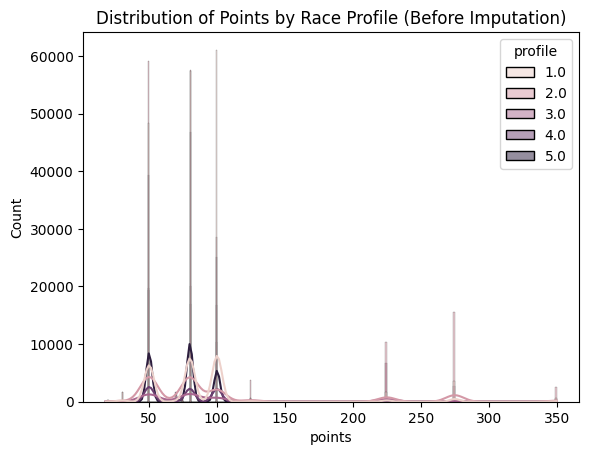

In [60]:
# Plot points distribution by race type (before imputation)
seaborn.histplot(data=df_races[df_races['points'].notnull()], x='points', hue='profile', kde=True)
plt.title("Distribution of Points by Race Profile (Before Imputation)")
plt.show()

Key Insights:

Distinct Point Clusters: Points seem to be distributed in specific clusters, with high counts around common point values (like 50, 100, 250). This suggests that points are often assigned in a standardized or tiered way, possibly based on the race type or prestige.

Race Profile Overlap: The different profiles (1.0 to 5.0) have significant overlap in point assignments. This means that, while some races may differ in difficulty or profile, they still frequently assign similar points.

High Peaks Around Standard Point Values: The peaks at specific values (like 50 and 100) are pronounced, showing that many races, regardless of profile, frequently assign these point values.

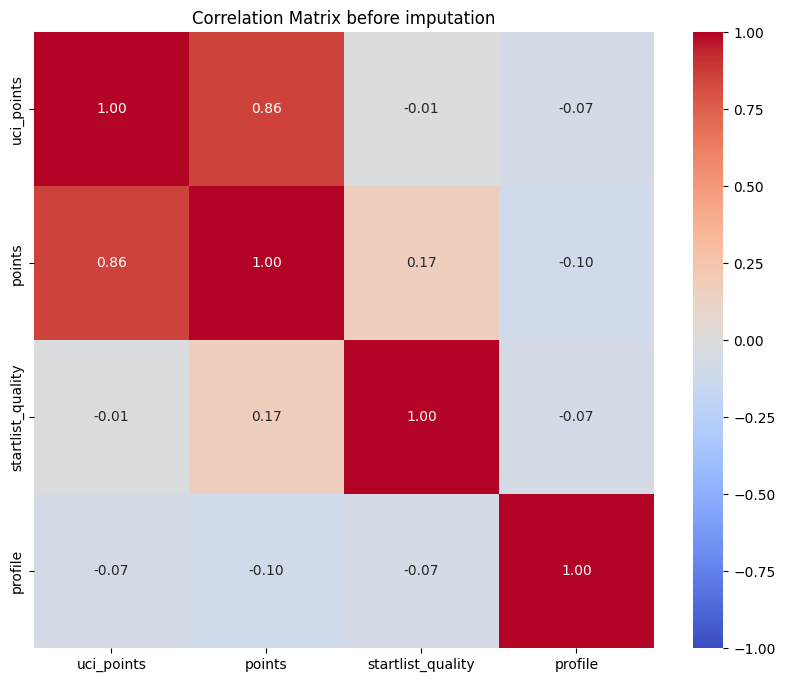

In [61]:
# check correlation before 
# Large shifts in correlation after imputation could indicate that the imputed values 
# deviate from the underlying relationships that exist in the data.
df_correlation = df_races[['uci_points', 'points', 'startlist_quality', 'profile']].copy()
corr_before = df_correlation[df_correlation['points'].notnull()].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_before, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix before imputation")
plt.show()

#### BayesianRidge

In [62]:
# Encode url with categorical encoding
label_encoder = LabelEncoder()
df_races['_url'] = label_encoder.fit_transform(df_races['_url'])

# Scale the data
scaler = StandardScaler()
df_races[['points', 'year']] = scaler.fit_transform(df_races[['points', 'year']])

columns_to_impute = ['points', '_url', 'year']

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['points'].notna()
points_non_null = df_no_nan.loc[known_points, 'points'].copy()
mask_fraction = 0.2  # Percentage of points to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'points'].copy()

# Mask the selected points
df_no_nan.loc[mask_indices, 'points'] = np.nan


# Define parameter grids
# Test different hyperparameter values for Bayesian Ridge
alpha_values = [1e-7, 1e-6, 1e-5, 1e-4] # regularization
max_iter_values = [50, 100, 200, 300]  # Maximum number of iterations
tol_values = [1e-4, 1e-3, 1e-2]  # Tolerance levels for convergence

# Dictionary to store errors for each parameter combination
errors = {}

# Iterate over all combinations of max_iter, tol, alpha_1, and alpha_2
for max_iter in max_iter_values:
    for tol in tol_values:
        for alpha_1 in alpha_values:
            for alpha_2 in alpha_values:
                # Initialize the IterativeImputer with BayesianRidge and current hyperparameters
                imputer = IterativeImputer(
                    estimator=BayesianRidge(max_iter=max_iter, tol=tol, alpha_1=alpha_1, alpha_2=alpha_2),
                    random_state=0,
                    min_value=min_point,
                    sample_posterior=True
                )
                
                # Fit and transform only on the copy with artificially masked values
                imputed_data = imputer.fit_transform(df_no_nan[columns_to_impute])
                df_imputed = pd.DataFrame(imputed_data, columns=columns_to_impute, index=df_no_nan.index)
                
                # Calculate error only on the masked points using the original values
                error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'points'])
                errors[(max_iter, tol, alpha_1, alpha_2)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_max_iter, optimal_tol, optimal_alpha_1, optimal_alpha_2 = optimal_params

# Display optimal parameters and associated error
print(f"Optimal parameters:")
print(f"max_iter={optimal_max_iter}, tol={optimal_tol}, alpha_1={optimal_alpha_1}, alpha_2={optimal_alpha_2}")
print(f"Minimum error: {errors[optimal_params]}")

# Perform final imputation on the original DataFrame with the selected parameters
final_imputer = IterativeImputer(
    estimator=BayesianRidge(max_iter=optimal_max_iter, tol=optimal_tol, alpha_1=optimal_alpha_1, alpha_2=optimal_alpha_2),
    random_state=0,
    min_value=min_point,
    sample_posterior=True
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_impute] = final_imputer.fit_transform(df_races[columns_to_impute])

# Inverse the standardization
df_races[['points', 'year']] = scaler.inverse_transform(df_races[['points', 'year']])

df_races['_url'] = df_races['_url'].round().astype(int)

# Inverse label encoding
df_races['_url'] = label_encoder.inverse_transform(df_races['_url'])

# Output the optimal parameters and final imputed DataFrame
print(f"Final imputation complete with optimal parameters.")

Optimal parameters:
max_iter=50, tol=0.0001, alpha_1=1e-07, alpha_2=1e-07
Minimum error: 325.08942390500204
Final imputation complete with optimal parameters.


The points are very few with respect to the total, so also this method results in roughly the same result

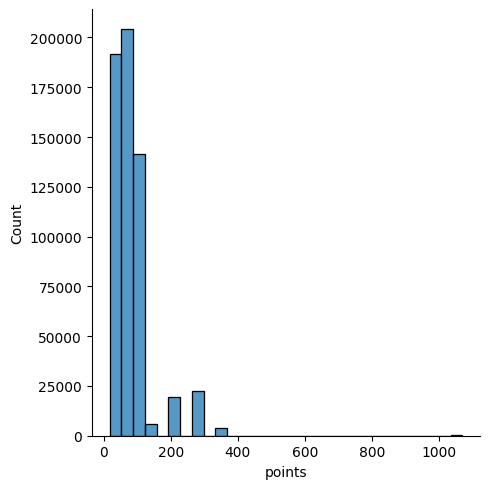

In [63]:
seaborn.displot(df_races,
            x="points",
            kind="hist",
            row_order="desc",
            bins=30)

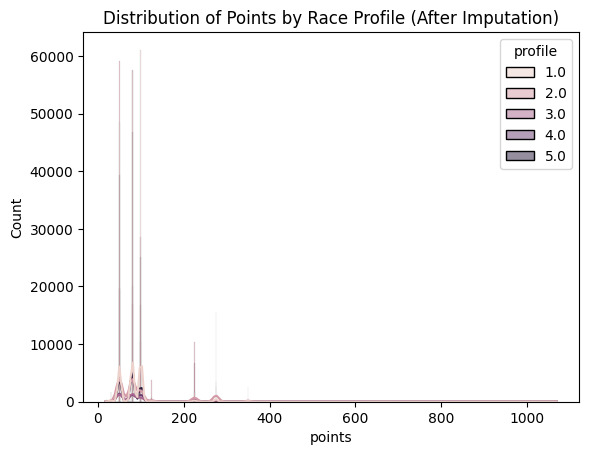

In [64]:
# Plot points distribution by race type (after imputation)
seaborn.histplot(data=df_races[df_races['points'].notnull()], x='points', hue='profile', kde=True)
plt.title("Distribution of Points by Race Profile (After Imputation)")
plt.show()

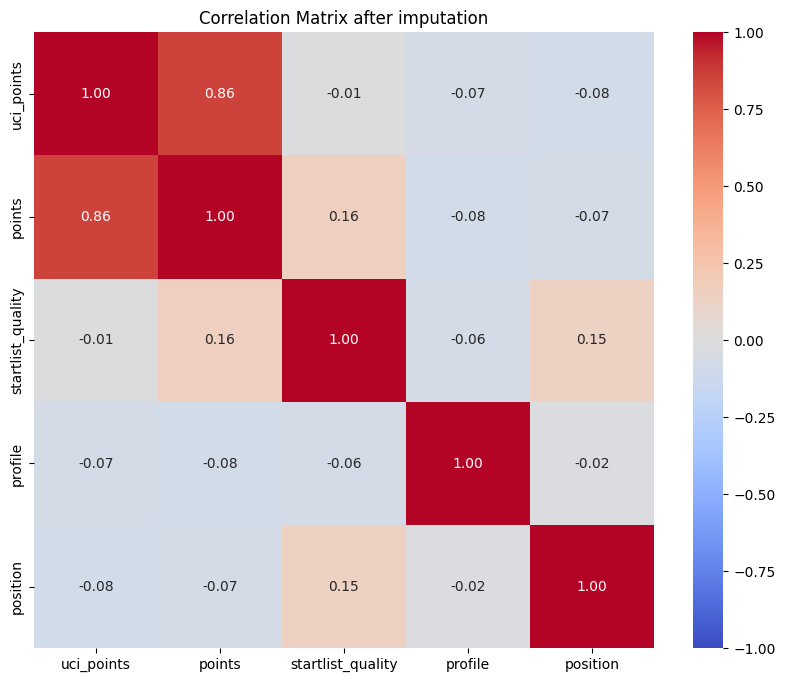

In [65]:
# check correlation after
df_correlation_after = df_races[['uci_points', 'points', 'startlist_quality', 'profile', 'position']].copy()
corr_after = df_correlation_after[df_correlation_after['points'].notnull()].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_after, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix after imputation")
plt.show()

In [66]:
# Kolmogorov-Smirnov Test

points_after_imputation = df_races['points']

test_before_after_distribution(points_before_imputation, points_after_imputation)


KS Test: Statistic = 0.007319893344880823, p-value = 3.7970969462912424e-14
Very small difference in distribution, the imputed data closely matches the original distribution.


Probably 477 missing points on about 500000 yelds a p value of 1, since visually thee distribution is preserved

In [67]:
df_races.isnull().sum()

_url                      0
name                      0
points                    0
uci_points           338779
length                    0
climb_total               0
profile                   0
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         159161
delta                     0
year                      0
dtype: int64

### UCI Points
We can now use points in the imputations since they have no more missing values left -> they are higly correlated so it makes sense

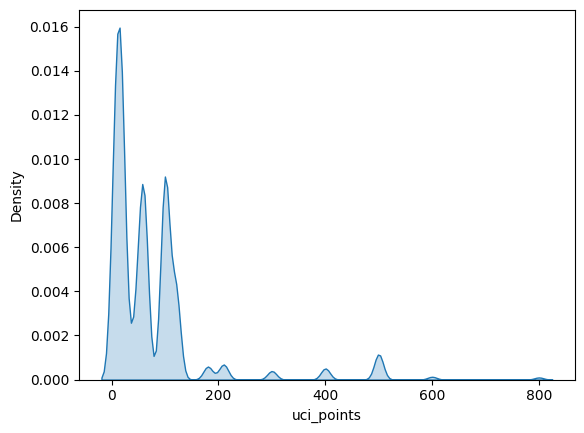

In [68]:
# Kernel Density Estimation UCI POINTS
seaborn.kdeplot(df_races["uci_points"], fill=True, label="uci_points")
plt.show()

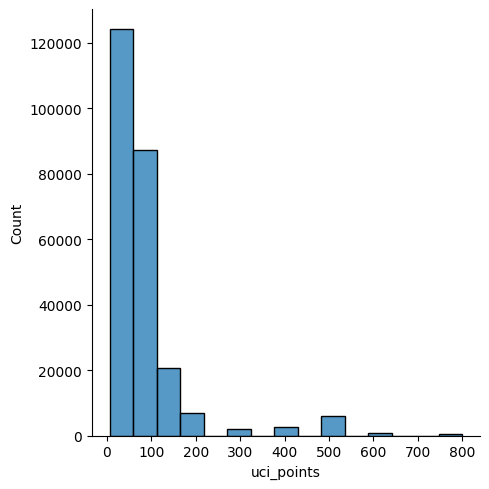

In [69]:
seaborn.displot(df_races,
            x="uci_points",
            kind="hist",
            row_order="desc",
            bins=15)

In [70]:
# Compute for testing after imputation
uci_points_before_imputation = df_races['uci_points'].dropna().copy()

# look at general statistics to compare
original_stats = df_races[df_races['uci_points'].notnull()]['uci_points'].describe()
original_stats

count    251034.000000
mean         74.596604
std         100.954300
min           6.000000
25%          16.000000
50%          60.000000
75%         100.000000
max         800.000000
Name: uci_points, dtype: float64

#### Select best K and impute KNNRegressor

In [71]:
# Scale the data
scaler = StandardScaler()
columns_to_scale = ['uci_points', 'points', 'startlist_quality', 'profile'] # use also points in the imputation
df_races[columns_to_scale] = scaler.fit_transform(df_races[columns_to_scale])

# Create a copy of the DataFrame for imputation while retaining all rows
df_no_nan = df_races.copy()

# Artificially mask some known values for testing
# Select non-null values to mask
known_points = df_no_nan['uci_points'].notna()
points_non_null = df_no_nan.loc[known_points, 'uci_points'].copy()
mask_fraction = 0.2  # Percentage of uci_points to mask
mask_size = int(mask_fraction * len(points_non_null))
mask_indices = np.random.choice(points_non_null.index, mask_size, replace=False)

# Store the original values for error calculation
original_values = df_no_nan.loc[mask_indices, 'uci_points'].copy()

# Mask the selected uci_points
df_no_nan.loc[mask_indices, 'uci_points'] = np.nan

# Test different k values for the imputer
k_values = [3,5,7,15,20]
weights_options = ['uniform', 'distance'] 
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

errors = {}

for k in k_values:
    for weight in weights_options:
        for algo in algorithms:
            # Initialize the imputer with the current k, weights, and algorithm
            imputer = IterativeImputer(
                estimator=KNeighborsRegressor(n_neighbors=k, weights=weight, algorithm=algo),
                random_state=0,
                max_iter=100
            )
            
            # Fit and transform only on the copy with artificially masked values
            imputed_data = imputer.fit_transform(df_no_nan[columns_to_scale])
            df_imputed = pd.DataFrame(imputed_data, columns=columns_to_scale, index=df_no_nan.index)
            
            # Calculate error only on the masked points using the original values
            error = mean_squared_error(original_values, df_imputed.loc[mask_indices, 'uci_points'])
            errors[(k, weight, algo)] = error

# Select the optimal parameters based on minimum error
optimal_params = min(errors, key=errors.get)
optimal_k, optimal_weight, optimal_algo = optimal_params

# Perform final imputation on the original DataFrame with the selected k
final_imputer = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=optimal_k, weights=optimal_weight, algorithm=optimal_algo),
    random_state=0,
    max_iter=100
)

# Fit and transform the original DataFrame, which includes real missing values
df_races[columns_to_scale] = final_imputer.fit_transform(df_races[columns_to_scale])

# Inverse the standardization
df_races[columns_to_scale] = scaler.inverse_transform(df_races[columns_to_scale])

# Output the optimal k and final imputed DataFrame
print(f"Optimal k: {optimal_k}, Optimal weights: '{optimal_weight}', Optimal algorithm: '{optimal_algo}'")


Optimal k: 7, Optimal weights: 'uniform', Optimal algorithm: 'auto'


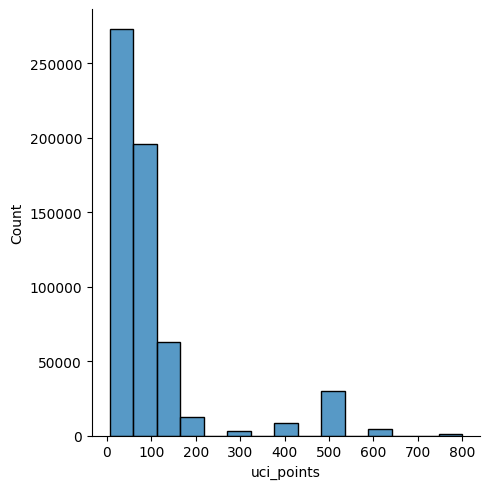

In [72]:
seaborn.displot(df_races,
            x="uci_points",
            kind="hist",
            row_order="desc",
            bins=15)

In [73]:
# check stats after imputation (outlier induce error on max min maybe ??)
imputed_stats = df_races['uci_points'].describe()
imputed_stats

count    589813.000000
mean         90.655509
std         125.705923
min           6.000000
25%          16.000000
50%          60.000000
75%         100.000000
max         800.000000
Name: uci_points, dtype: float64

In [74]:
# Kolmogorov-Smirnov Test

uci_points_after_imputation = df_races['uci_points']

test_before_after_distribution(uci_points_before_imputation, uci_points_after_imputation)


KS Test: Statistic = 0.09109140663714871, p-value = 0.0
Minor difference in distribution, the imputed data is similar to the original distribution with slight deviations.


A p value of 0 could be justyfied with large sample size and missing value counts (about 70% over the total). So the difference in the actual distribution are not too much, but the statistics obviously sufferf major change because we addes some more values

In [75]:
df_races.isnull().sum()

_url                      0
name                      0
points                    0
uci_points                0
length                    0
climb_total               0
profile                   0
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         159161
delta                     0
year                      0
dtype: int64

### Cyclist team

To impute the missing cyclist_team attribute, the following features can be most helpful for prediction:

Name: Certain teams might specialize in specific races or are more likely to be represented in certain high-prestige races (e.g., Tour de France).
Points and Alternative Points: High-point races may attract specific teams with a strong track record or history in those races.
Total Meters Climbed and Race Profile: Teams often have rosters built for specific types of races (e.g., flat vs. mountainous); some teams are known for having climbers while others specialize in flat stages.
Is_X: Certain teams have cyclists skilled in specific race types (e.g., gravel races).
Startlist Quality: This indicates the general level of competition, which could correlate with specific high-ranking teams present in more competitive races.

In [76]:
df_races["cyclist_team"].describe()

count                              430652
unique                                 91
top       liberty-seguros-wurth-team-2005
freq                                 8869
Name: cyclist_team, dtype: object

In [77]:
# Calculate distribution before imputation
before_imputation_dist = df_races['cyclist_team'].value_counts(normalize=True)

# Compute for testing after imputation
cyclist_team_before_imputation = df_races['cyclist_team'].dropna().copy()

Text(0, 0.5, 'Frequency')

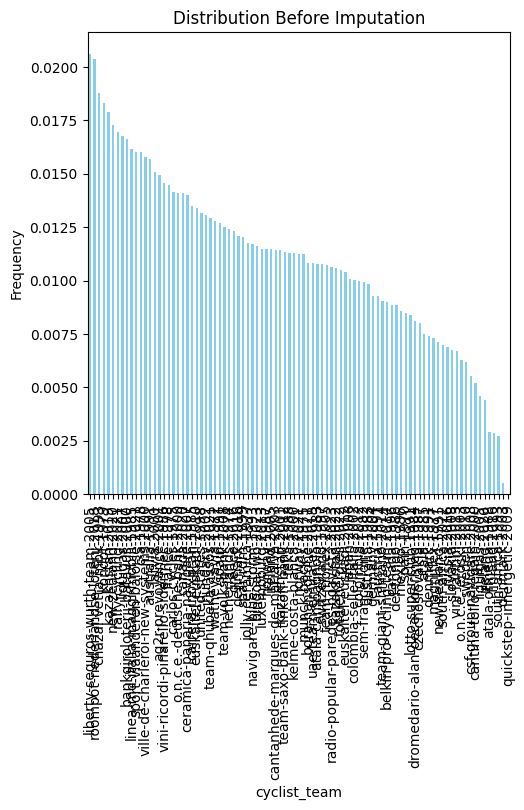

In [78]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
before_imputation_dist.plot(kind='bar', color='skyblue')
plt.title("Distribution Before Imputation")
plt.ylabel("Frequency")

#### Set values to Nan because of string poblem

In [79]:
df_races[["cyclist_team"]].head() # NaN calues are set to --> None
# convert them
df_races["cyclist_team"] = df_races["cyclist_team"].replace({None: np.nan})

In [80]:
df_races["cyclist_team"]

0                             norway-1987
1                             norway-1987
2                              spain-1991
3                              spain-1991
4                                     NaN
                       ...               
589860                    kazakhstan-2022
589861                       denmark-2016
589862                       denmark-2016
589863    liberty-seguros-wurth-team-2005
589864            team-qhubeka-assos-2021
Name: cyclist_team, Length: 589813, dtype: object

#### Random imputing based on original distribution (Best)
If teams have Team A = 60%, Team B = 30%, Team C = 10% --> For each missing value in cyclist_team, the random imputer would Assign Team A 60% of the time, Team B 30% of the time, Team C 10% of the time.

In [81]:
# Get the value counts of the original non-missing values in cyclist_team
original_distribution = df_races['cyclist_team'].value_counts(normalize=True)

# Fill missing values by sampling from the original distribution
df_races['cyclist_team'] = df_races['cyclist_team'].apply(
    lambda x: np.random.choice(original_distribution.index, p=original_distribution.values) if pd.isnull(x) else x
)

In [82]:
df_races.isnull().sum()

_url                 0
name                 0
points               0
uci_points           0
length               0
climb_total          0
profile              0
startlist_quality    0
date                 0
position             0
cyclist              0
cyclist_age          0
is_tarmac            0
is_cobbled           0
is_gravel            0
cyclist_team         0
delta                0
year                 0
dtype: int64

Text(0, 0.5, 'Frequency')

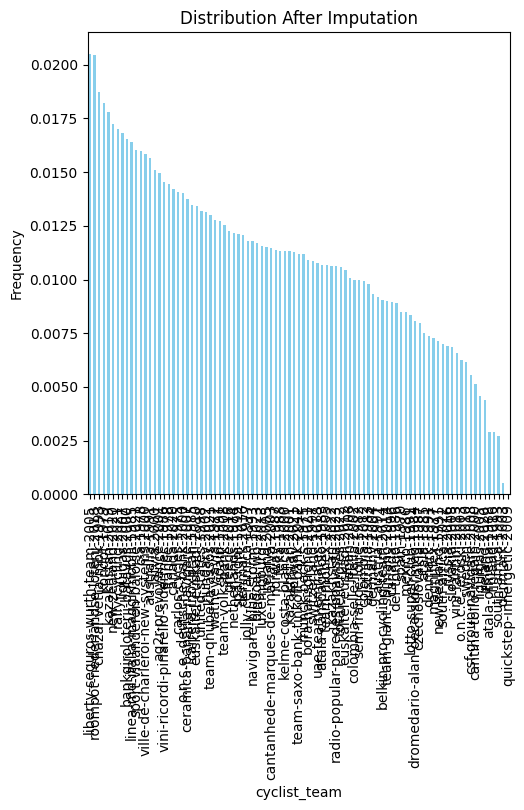

In [83]:
# Calculate distribution after imputation
after_imputation_dist = df_races['cyclist_team'].value_counts(normalize=True)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
after_imputation_dist.plot(kind='bar', color='skyblue')
plt.title("Distribution After Imputation")
plt.ylabel("Frequency")

In [84]:
cyclist_team_after_imputation = df_races['cyclist_team']

test_before_after_distribution(cyclist_team_before_imputation, cyclist_team_after_imputation)   


KS Test: Statistic = 0.0004733244315523466, p-value = 0.9999999972182979
Very small difference in distribution, the imputed data closely matches the original distribution.


## Saving dataframes without missing values

In [85]:
# Races
df_races.to_csv('df_races_no_missing.csv', index=False)

# Cyclists
df_cyclists.to_csv('df_cyclists_no_missing.csv', index=False)